In [2]:
# Import Libraries
# Define Mediapose Landmarks, Doses, Drawing Utilities, connections, face_mesh
# Display The Image
# Iterate through the Landmarks in the Image
# Draw the Landmarks on the Image
# Create the 2D Graph with the Trackers and Connectors of the Image
# Create a Detect Pose Function
# Improve the Accuracy and Precision of the Trackers and Connectors of the Image
# Do Image Segmentation on the Image
# List and Store the Landmarks of the Image
# Create the 3D Graph with the Trackers and Connectors of the Image
# Display the Video
# Do the Pose Detection on the Video 
# Draw the Trackers and Connectors on the Video Frames
# Create a 3D Wireframe for the Trackers and Connectors found on the Image
# Detect the Angles in Images
# Classify the Poses based on the Angles in Images
# Do the Same for Videos shot in Real-Time

In [3]:
import cv2
import mediapipe as mp
import urllib.request
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import PyQt5
from PIL import Image
from IPython.display import Video
import imageio
import ffmpeg
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
from time import time
import math 
import mpl_toolkits.mplot3d.axes3d as p3

In [13]:
poselandmarks_list = []

for idx, elt in enumerate(mp_pose.PoseLandmark):
    lm_str = repr(elt).split('.')[1].split(':')[0]
    poselandmarks_list.append(lm_str)


def scale_axes(ax):
    # Scale axes properly
    # https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.zaxis.set_ticks([])

def plot_data(data, ax, rotate=True):
    if rotate:
        ax.scatter(data[0, :], data[2, :], -data[1, :])

        for i in pose_connections:
            ax.plot3D([data[0, i[0]], data[0, i[1]]],
                      [data[2, i[0]], data[2, i[1]]],
                      [-data[1, i[0]], -data[1, i[1]]],
                      color='k', lw=1)

        ax.view_init(elev=10, azim=-60)

    else:
        ax.scatter(data[0, :], data[1, :], data[2, :])

        for i in pose_connections:
            ax.plot3D([data[0, i[0]], data[0, i[1]]],
                      [data[1, i[0]], data[1, i[1]]],
                      [data[2, i[0]], data[2, i[1]]],
                      color='k', lw=1)

        ax.view_init(elev=-90, azim=-90)


def rotate_and_save(figure, axis, filename, save=False):
    def init():
        return figure,

    def animate(i):
        axis.view_init(elev=10., azim=i)
        return figure,

    anim = animation.FuncAnimation(figure, animate, init_func=init,
                                   frames=360, interval=20, blit=True)
    plt.close()

    if save:
        with imageio.get_writer(filename, fps=30) as writer:
            for i in range(360):
                axis.view_init(elev=10., azim=i)
                figure.canvas.draw()
                image = np.frombuffer(figure.canvas.tostring_rgb(), dtype='uint8')
                image = image.reshape(figure.canvas.get_width_height()[::-1] + (3,))
                writer.append_data(image)


def time_animate(data, figure, ax, rotate_data=True, rotate_animation=False):
    frame_data = data[:, :, 0]
    if rotate_data:
        plot = [ax.scatter(frame_data[0, :], -frame_data[2, :], -frame_data[1, :], color='tab:blue')]

        for i in pose_connections:
            plot.append(ax.plot3D([frame_data[0, i[0]], frame_data[0, i[1]]],
                                  [-frame_data[2, i[0]], -frame_data[2, i[1]]],
                                  [-frame_data[1, i[0]], -frame_data[1, i[1]]],
                                  color='k', lw=1)[0])

        ax.view_init(elev=10, azim=120)

    else:
        ax.scatter(frame_data[0, :], frame_data[1, :], frame_data[2, :], color='tab:blue')

        for i in pose_connections:
            ax.plot3D([frame_data[0, i[0]], frame_data[0, i[1]]],
                      [frame_data[1, i[0]], frame_data[1, i[1]]],
                      [frame_data[2, i[0]], frame_data[2, i[1]]],
                      color='k', lw=1)

        ax.view_init(elev=-90, azim=-90)

    scale_axes(ax)

    def init():
        return figure,

    def animate(i):
        frame_data = data[:, :, i]

        for idxx in range(len(plot)):
            plot[idxx].remove()

        plot[0] = ax.scatter(frame_data[0, :], -frame_data[2, :], -frame_data[1, :], color='tab:blue')

        idx = 1
        for pse in pose_connections:
            plot[idx] = ax.plot3D([frame_data[0, pse[0]], frame_data[0, pse[1]]],
                                  [-frame_data[2, pse[0]], -frame_data[2, pse[1]]],
                                  [-frame_data[1, pse[0]], -frame_data[1, pse[1]]],
                                  color='k', lw=1)[0]
            idx += 1

        if rotate_animation:
            ax.view_init(elev=10., azim=120 + (360 / data.shape[-1]) * i)

        return figure,

    anim = animation.FuncAnimation(figure, animate, init_func=init,
                                   frames=72, interval=20, blit=True)

    plt.close()

    return anim

In [4]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
mp_drawing = mp.solutions.drawing_utils
pose_connections = mp.solutions.pose.POSE_CONNECTIONS
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
mp_pose = mp.solutions.pose
mp_face_mesh = mp.solutions.face_mesh

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<function matplotlib.pyplot.show(close=None, block=None)>

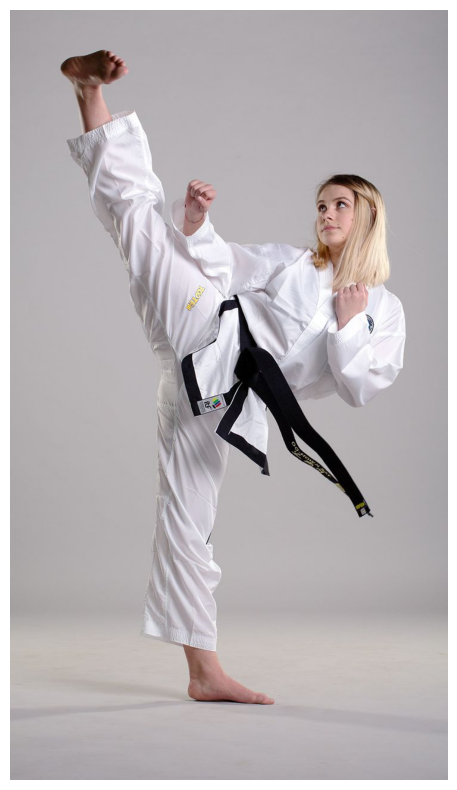

In [5]:
sample_img = cv2.imread('img9.jpg')
plt.figure(figsize = [10, 10])
plt.axis('off')
plt.imshow(sample_img[:,:,::-1])
plt.show

In [6]:
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
if results.pose_landmarks:
    for i in range(5):
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}') 

NOSE:
x: 0.729133129119873
y: 0.27185264229774475
z: -0.36559784412384033
visibility: 0.9999991655349731

LEFT_EYE_INNER:
x: 0.7524920105934143
y: 0.2607945501804352
z: -0.33885374665260315
visibility: 0.9999974966049194

LEFT_EYE:
x: 0.7626633644104004
y: 0.2619466185569763
z: -0.3393465578556061
visibility: 0.9999948740005493

LEFT_EYE_OUTER:
x: 0.7715820074081421
y: 0.26295849680900574
z: -0.33893463015556335
visibility: 0.999996542930603

RIGHT_EYE_INNER:
x: 0.7299298644065857
y: 0.25859543681144714
z: -0.3268909752368927
visibility: 0.9999986886978149



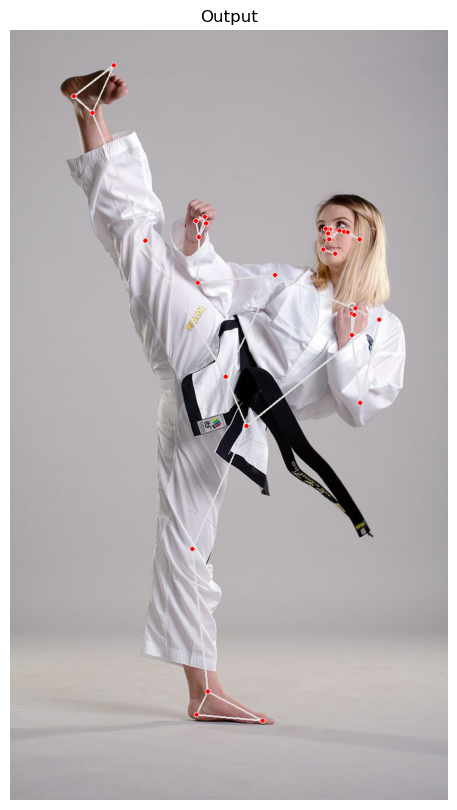

In [7]:
img_copy = sample_img.copy()
 
if results.pose_landmarks: 
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    fig = plt.figure(figsize = [10, 10])
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

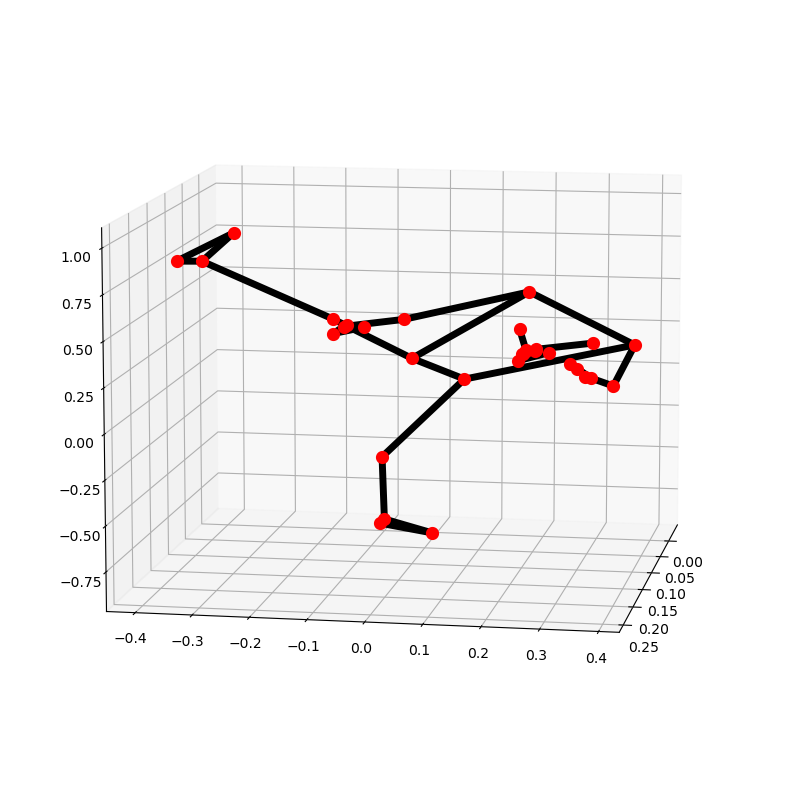

In [8]:
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

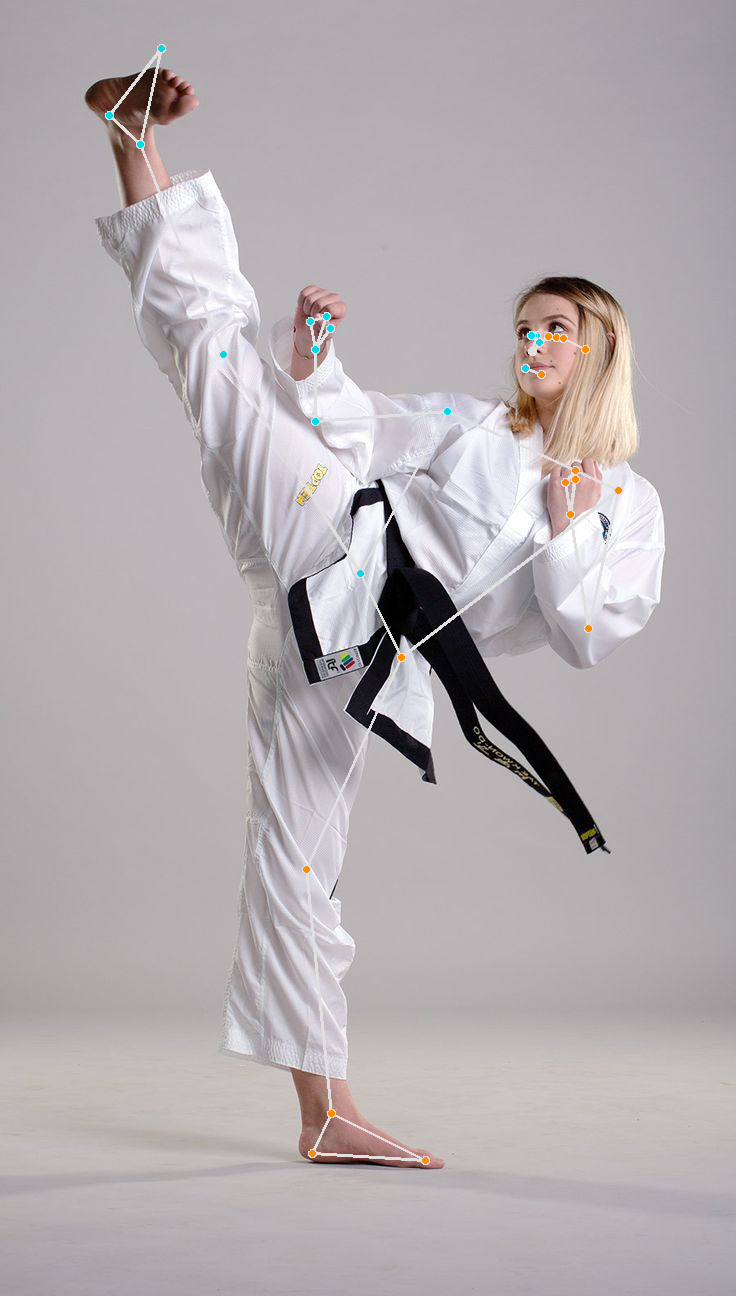

In [9]:
file = 'img9.jpg'
with mp_pose.Pose(static_image_mode=True, 
		  model_complexity=2,
                  enable_segmentation=True) as pose:

    image = cv2.imread(file)
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


annotated_image = image.copy()

mp_drawing.draw_landmarks(annotated_image, 
                          results.pose_landmarks, 
                          mp_pose.POSE_CONNECTIONS,
                          landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())


filename = "pose_wireframe.png"
cv2.imwrite(filename, annotated_image)
display(Image.open(filename))

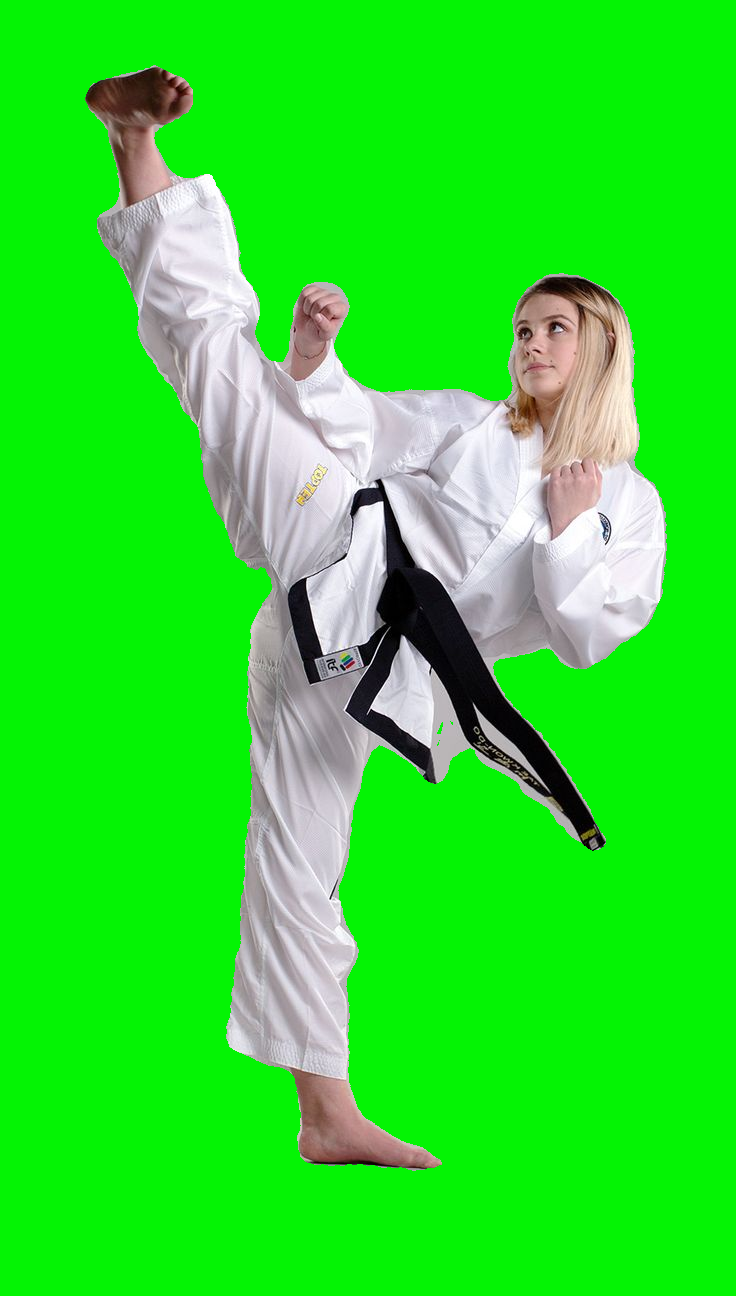

In [10]:
segmented_image = image.copy()
tightness = .3
condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > tightness
bg_image = np.zeros(image.shape, dtype=np.uint8)
bg_image[:] = [4, 244, 4]
segmented_image = np.where(condition, segmented_image, bg_image)

filename = "pose_green_screen.png"
cv2.imwrite(filename, segmented_image)
display(Image.open(filename))

In [11]:
#Storing the Landmarks
poselandmarks_list = []
for idx, elt in enumerate(mp_pose.PoseLandmark):
    lm_str = repr(elt).split('.')[1].split(':')[0]
    poselandmarks_list.append(lm_str)

In [14]:
data = np.empty((3, len(mp_holistic.PoseLandmark)))

landmarks = results.pose_world_landmarks.landmark
for i in range(len(mp_holistic.PoseLandmark)):
    data[:, i] = (landmarks[i].x, landmarks[i].y, landmarks[i].z)   


fig = plt.figure()
fig.set_size_inches(5, 5, True)
ax = fig.add_subplot(projection='3d')

plot_data(data, ax)
scale_axes(ax)

filename = 'pose_rotation.mp4'
rotate_and_save(fig, ax, filename, save=True)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f89c8048000] Warning: data is not aligned! This can lead to a speed loss


In [15]:
def detectPose(image, pose, display=True):
    output_image = image.copy()
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    results = pose.process(imageRGB)
    height, width, _ = image.shape
    landmarks = []

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)

        for landmark in results.pose_landmarks.landmark:
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    if display:
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');

        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

    else:
        return output_image, landmarks

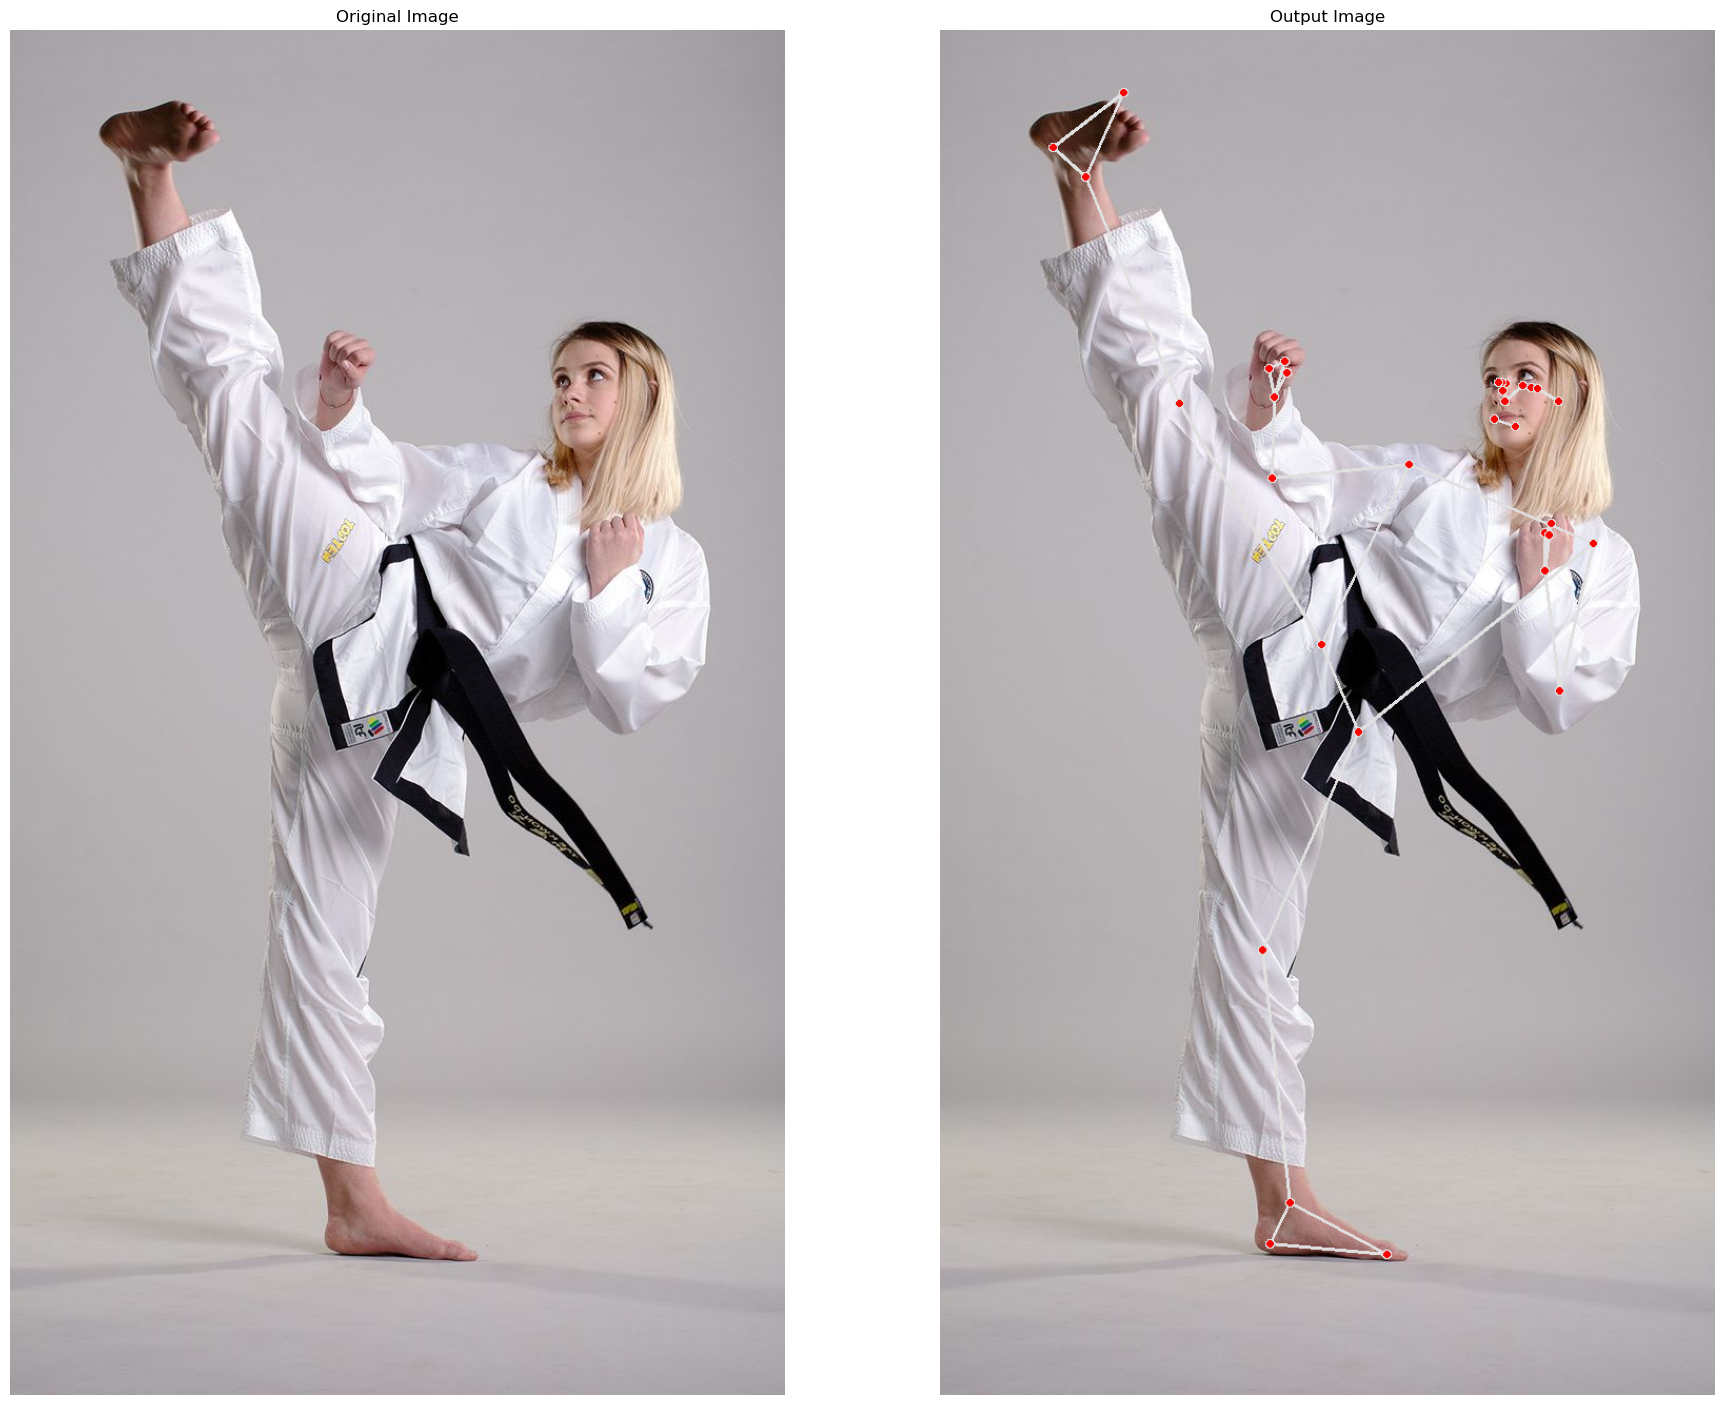

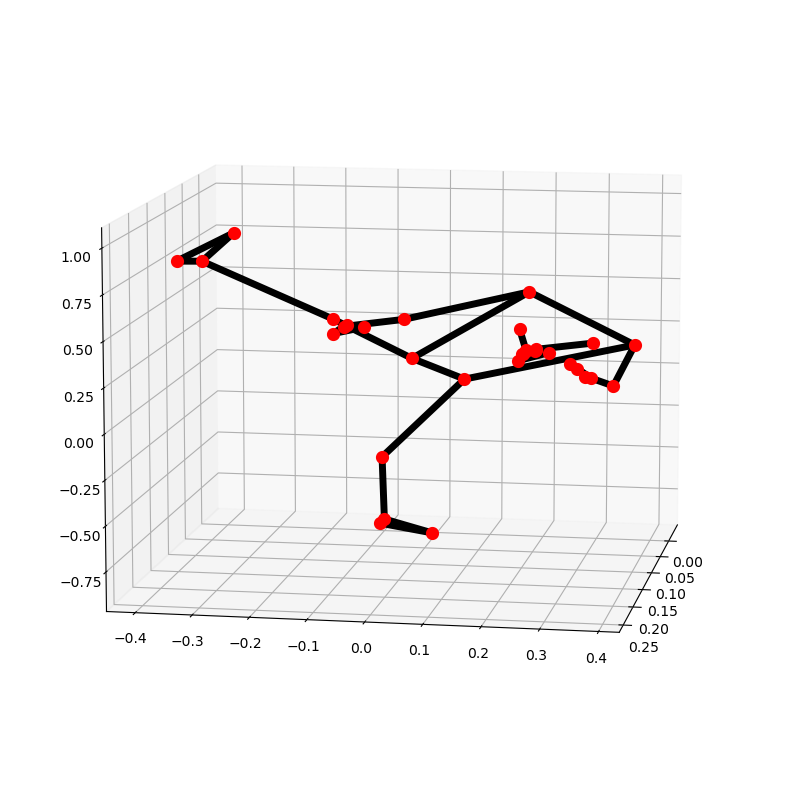

In [16]:
image = cv2.imread('img9.jpg')
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
detectPose(image, pose, display=True)

In [22]:
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)
video = cv2.VideoCapture(0)
video = cv2.VideoCapture('./Media_1/walking.mp4')
time1 = 0
 
while video.isOpened():
    ok, frame = video.read()
    if not ok:
        break
    
    frame = cv2.flip(frame, 1)
    
    frame_height, frame_width, _ =  frame.shape
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    frame, _ = detectPose(frame, pose_video, display=False)
    time2 = time()

    if (time2 - time1) > 0:
        frames_per_second = 1.0 / (time2 - time1)
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    
    time1 = time2
    cv2.imshow('Pose Detection', frame)
    k = cv2.waitKey(1) & 0xFF
    
    if(k == 27):
        break

video.release()
cv2.destroyAllWindows()

In [23]:
poselandmarks_list = []
for idx, elt in enumerate(mp_pose.PoseLandmark):
    lm_str = repr(elt).split('.')[1].split(':')[0]
    poselandmarks_list.append(lm_str)

In [24]:
file = './Media_1/squat_18.mp4'
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    cap = cv2.VideoCapture(file)
    if cap.isOpened() == False:
        print("Error opening video stream or file")
        raise TypeError

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    data = np.empty((3, len(poselandmarks_list), length))    
    frame_num = 0
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        results = pose.process(image)
        
        landmarks = results.pose_world_landmarks.landmark
        for i in range(len(mp_pose.PoseLandmark)):
            data[:, i, frame_num] = (landmarks[i].x, landmarks[i].y, landmarks[i].z)  
        
        frame_num += 1
    cap.release()

In [25]:
fig = plt.figure()
fig.set_size_inches(5, 5, True)
ax = fig.add_subplot(projection='3d')

anim = time_animate(data, fig, ax)

anim.save('walking_wireframe.mp4', fps=30, extra_args=['-vcodec', 'libx264'], dpi=300)


In [26]:
def calculateAngle(landmark1, landmark2, landmark3):
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3

    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))

    if angle < 0:
        angle += 360

    return angle

In [27]:
def classifyPose(landmarks, output_image, display=False):
    label = 'Unknown Pose'
    color = (0, 0, 255)

    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   

    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])
 
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])
 
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
 
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:

        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 110:
 
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
 
                if left_knee_angle > 90 and left_knee_angle < 120 or right_knee_angle > 90 and right_knee_angle < 120:

                    label = 'Warrior II Pose' 
                        
   
            if left_knee_angle > 160 and left_knee_angle < 195 and right_knee_angle > 160 and right_knee_angle < 195:
 
                label = 'T Pose'
 
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:

        if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 25 and right_knee_angle < 45:

            label = 'Tree Pose'
                
    if label != 'Unknown Pose':
        
        color = (0, 255, 0)  
    
    cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
   
    if display:

        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    else:

        return output_image, label

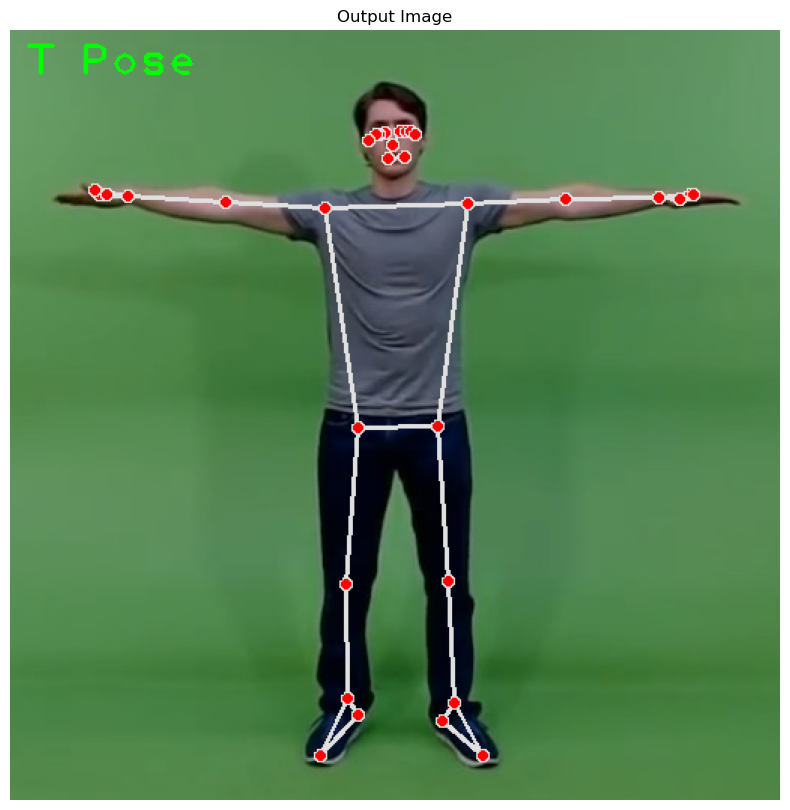

In [34]:
image = cv2.imread('download.jpeg')
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

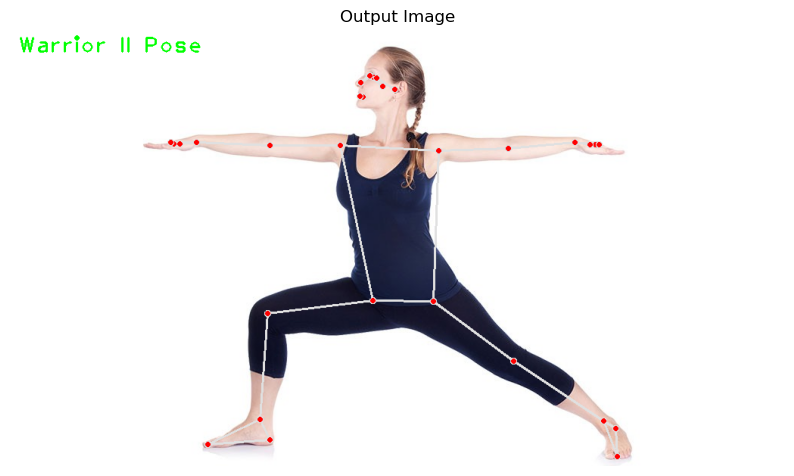

In [28]:
image = cv2.imread('img2.jpg')
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

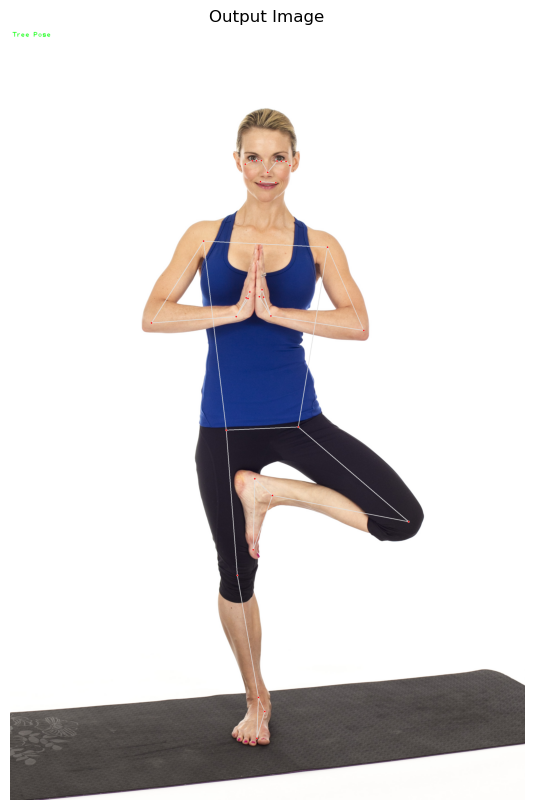

In [30]:
image = cv2.imread('img5.jpg')
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

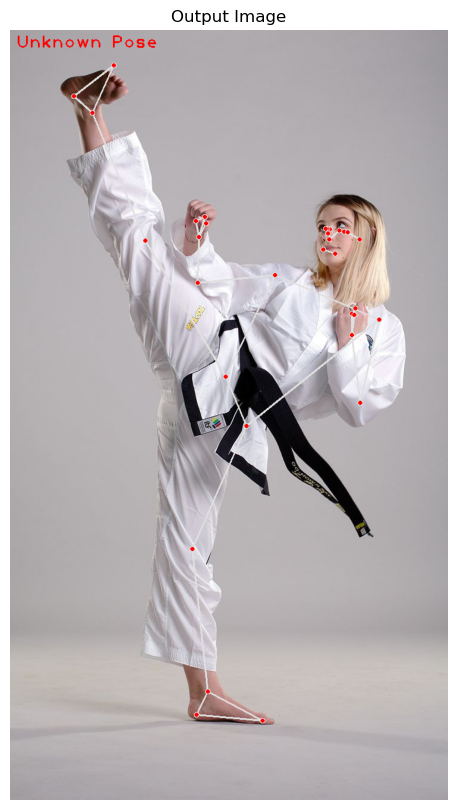

In [ ]:
image = cv2.imread('img9.jpg')
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

In [32]:
camera_video = cv2.VideoCapture('./Media_3/Tree.mp4')

cv2.namedWindow('Pose Classification', cv2.WINDOW_NORMAL)

while camera_video.isOpened():

    ok, frame = camera_video.read()

    if not ok:
        continue
    
    frame = cv2.flip(frame, 1)
    
    frame_height, frame_width, _ =  frame.shape
    
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))

    frame, landmarks = detectPose(frame, pose_video, display=False)

    if landmarks:

        frame, _ = classifyPose(landmarks, frame, display=False)

    cv2.imshow('Pose Classification', frame)

    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed.
    if(k == 27):
        
        # Break the loop.
        break
 
# Release the VideoCapture object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [33]:
camera_video = cv2.VideoCapture(0)

cv2.namedWindow('Pose Classification', cv2.WINDOW_NORMAL)

if not camera_video.isOpened():
    print("Could not open webcam")
    exit()

while True:

    ok, frame = camera_video.read()

    if not ok:
        continue
    
    frame = cv2.flip(frame, 1)
    
    frame_height, frame_width, _ =  frame.shape
    
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))

    frame, landmarks = detectPose(frame, pose_video, display=False)

    if landmarks:

        frame, _ = classifyPose(landmarks, frame, display=False)

    cv2.imshow('Pose Classification', frame)

    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed.
    if(k == 27):
        
        # Break the loop.
        break
 
# Release the VideoCapture object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 